# Arterial line study

This notebook reproduces the arterial line study in MIMIC-III. The following is an outline of the notebook:

1. Generate necessary materialized views in SQL
2. Combine materialized views and acquire a single dataframe
3. Write this data to file for use in R

The R code then evaluates whether an arterial line is associated with mortality after propensity matching.

Note that the original arterial line study used a genetic algorithm to select the covariates in the propensity score. We omit the genetic algorithm step, and instead use the final set of covariates described by the authors. For more detail, see:

> Hsu DJ, Feng M, Kothari R, Zhou H, Chen KP, Celi LA. The association between indwelling arterial catheters and mortality in hemodynamically stable patients with respiratory failure: a propensity score analysis. CHEST Journal. 2015 Dec 1;148(6):1470-6.

In [ ]:
# Install OS dependencies.  This only needs to be run once for each new notebook instance.
!conda install --yes --name JupyterSystemEnv --channel r r-essentials=1.7
!pip install PyAthena

In [67]:
from pyathena import connect
from pyathena.util import as_pandas
from __future__ import print_function

# Import libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
from botocore.client import ClientError
# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML
%matplotlib inline


s3 = boto3.resource('s3')
client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
my_session = boto3.session.Session()
region = my_session.region_name
athena_query_results_bucket = 'aws-athena-query-results-'+account_id+'-'+region

try:
    s3.meta.client.head_bucket(Bucket=athena_query_results_bucket)
except ClientError:
    bucket = s3.create_bucket(Bucket=athena_query_results_bucket)
    print('Creating bucket '+athena_query_results_bucket)
cursor = connect(s3_staging_dir='s3://'+athena_query_results_bucket+'/athena/temp').cursor()


# The Glue database name of your MIMIC-III parquet data
gluedatabase="mimiciii"

# location of the queries to generate aline specific materialized views
aline_path = './'

# location of the queries to generate materialized views from the MIMIC code repository
concepts_path = '../../concepts/'

In [68]:
print(datetime.datetime.now())

2019-06-04 17:12:52.999991


# 1 - Generate materialized views

Before generating the aline cohort, we require the following materialized views to be already generated:

* angus - from `angus.sql`
* heightweight - from `HeightWeightQuery.sql`
* aline_vaso_flag - from `aline_vaso_flag.sql`

You can generate the above by executing the below codeblock. If you haven't changed the directory structure, the below should work, otherwise you may need to modify the `concepts_path` variable above.

In [69]:
# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.angus_sepsis;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(concepts_path,'sepsis/angus-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'angus_sepsis\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')

# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.heightweight;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(concepts_path,'demographics/HeightWeightQuery-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'heightweight\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')


# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.aline_vaso_flag;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(aline_path,'aline_vaso_flag-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'aline_vaso_flag\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')


# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.ventsettings;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(concepts_path,'durations/ventilation-settings-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'vent_settings\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')


# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.ventdurations;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(concepts_path,'durations/ventilation-durations-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'vent_durations\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')

Generating table 'angus_sepsis' using ../../concepts/sepsis/angus-athena.sql ... done.
Generating table 'heightweight' using ../../concepts/demographics/HeightWeightQuery-athena.sql ... done.
Generating table 'aline_vaso_flag' using ./aline_vaso_flag-athena.sql ... done.
Generating table 'vent_settings' using ../../concepts/durations/ventilation-settings-athena.sql ... done.
Generating table 'vent_durations' using ../../concepts/durations/ventilation-durations-athena.sql ... done.


Now we generate the *aline_cohort* table using the aline_cohort.sql file.

Afterwards, we can generate the remaining 6 materialized views in any order, as they all depend on only *aline_cohort* and raw MIMIC-III data.

In [70]:
# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.aline_cohort_all;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(aline_path,'aline_cohort-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'aline_cohort_all\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')


# Load in the query from file
query='DROP TABLE IF EXISTS DATABASE.aline_cohort;'
cursor.execute(query.replace("DATABASE", gluedatabase))
f = os.path.join(aline_path,'aline_final_cohort-athena.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'aline_cohort\' using {} ...'.format(f),end=' ')
cursor.execute(query.replace("DATABASE", gluedatabase))
print('done.')

Generating table 'aline_cohort_all' using ./aline_cohort-athena.sql ... done.
Generating table 'aline_cohort' using ./aline_final_cohort-athena.sql ... done.


In [71]:
query = """
select
icustay_id
, exclusion_readmission
, exclusion_shortstay
, exclusion_vasopressors
, exclusion_septic
, exclusion_aline_before_admission
, exclusion_not_ventilated_first24hr
, exclusion_service_surgical
from DATABASE.aline_cohort_all
"""

cursor.execute(query.replace("DATABASE", gluedatabase))
# Load the result of the query into a dataframe
df = as_pandas(cursor)

# print out exclusions
idxRem = df['icustay_id'].isnull()
for c in df.columns:
    if 'exclusion_' in c:
        print('{:5d} - {}'.format(df[c].sum(), c))
        idxRem[df[c]==1] = True   
        
# final exclusion (excl sepsis/something else)
print('Will remove {} of {} patients.'.format(np.sum(idxRem), df.shape[0]))


print('')
print('')
print('Reproducing the flow of the flowchart from Chest paper.')

# first stay
idxRem = (df['exclusion_readmission']==1) | (df['exclusion_shortstay']==1)
print('{:5d} - removing {:5d} ({:2.2f}%) patients - short stay // readmission.'.format(
        df.shape[0], np.sum(idxRem), 100.0*np.mean(idxRem)))
df = df.loc[~idxRem,:]

idxRem = df['exclusion_not_ventilated_first24hr']==1
print('{:5d} - removing {:5d} ({:2.2f}%) patients - not ventilated in first 24 hours.'.format(
        df.shape[0], np.sum(idxRem), 100.0*np.mean(idxRem)))

df = df.loc[df['exclusion_not_ventilated_first24hr']==0,:]

print('{:5d}'.format(df.shape[0]))
idxRem = df['icustay_id'].isnull()
for c in ['exclusion_septic', 'exclusion_vasopressors',
            'exclusion_aline_before_admission', 'exclusion_service_surgical']:
    print('{:5s} - removing {:5d} ({:2.2f}%) patients - additional {:5d} {:2.2f}% - {}'.format(
            '', df[c].sum(), 100.0*df[c].mean(),
            np.sum((idxRem==0)&(df[c]==1)), 100.0*np.mean((idxRem==0)&(df[c]==1)),
            c))
    idxRem = idxRem | (df[c]==1)

df = df.loc[~idxRem,:]
print('{} - final cohort.'.format(df.shape[0]))

14024 - exclusion_readmission
 8948 - exclusion_shortstay
17399 - exclusion_vasopressors
17007 - exclusion_septic
12961 - exclusion_aline_before_admission
29448 - exclusion_not_ventilated_first24hr
15499 - exclusion_service_surgical
Will remove 49906 of 52430 patients.


Reproducing the flow of the flowchart from Chest paper.
52430 - removing 20816 (39.70%) patients - short stay // readmission.
31614 - removing 15737 (49.78%) patients - not ventilated in first 24 hours.
15877
      - removing  5717 (36.01%) patients - additional  5717 36.01% - exclusion_septic
      - removing  9110 (57.38%) patients - additional  5751 36.22% - exclusion_vasopressors
      - removing  7601 (47.87%) patients - additional  1598 10.06% - exclusion_aline_before_admission
      - removing  6748 (42.50%) patients - additional   287 1.81% - exclusion_service_surgical
2524 - final cohort.


The following codeblock loads in the SQL from each file in the aline subfolder and executes the query to generate the materialized view. We specifically exclude the aline_cohort.sql file as we have already executed it above. Again, the order of query execution does not matter for these queries. Note also that the filenames are the same as the created materialized view names for convenience.

In [72]:
# get a list of all files in the subfolder
aline_queries = [f for f in os.listdir(aline_path) 
                 # only keep the filename if it is actually a file (and not a directory)
                if os.path.isfile(os.path.join(aline_path,f))
                 # and only keep the filename if it is an SQL file
                & f.endswith('-athena.sql')
                # and we do *not* want aline_cohort - it's generated above
                & (f != 'aline_cohort-athena.sql') & (f != 'aline_final_cohort-athena.sql') & (f != 'aline_vaso_flag-athena.sql')]

for f in aline_queries:
    # Load in the query from file
    table=f.split('-')
    query='DROP TABLE IF EXISTS DATABASE.{};'.format(table[0])
    cursor.execute(query.replace("DATABASE", gluedatabase))
    print('Executing {} ...'.format(f), end=' ')
    
    with open(os.path.join(aline_path,f)) as fp:
        query = ''.join(fp.readlines())
    cursor.execute(query.replace("DATABASE", gluedatabase))
    print('done.')


Executing aline_labs-athena.sql ... done.
Executing aline_sedatives-athena.sql ... done.
Executing aline_sofa-athena.sql ... done.
Executing aline_vitals-athena.sql ... done.
Executing aline_bmi-athena.sql ... done.
Executing aline_icd-athena.sql ... done.


Summarize the cohort exclusions before we pull all the data together.

# 2 - Extract all covariates and outcome measures

We now aggregate all the data from the various views into a single dataframe.

In [73]:
# Load in the query from file
query = """
--FINAL QUERY
select
  co.subject_id, co.hadm_id, co.icustay_id

  -- static variables from patient tracking tables
  , co.age
  , co.gender
  -- , co.gender_num -- gender, 0=F, 1=M
  , co.intime as icustay_intime
  , co.day_icu_intime -- day of week, text
  --, co.day_icu_intime_num -- day of week, numeric (0=Sun, 6=Sat)
  , co.hour_icu_intime -- hour of ICU admission (24 hour clock)
  , case 
      when co.hour_icu_intime >= 7
       and co.hour_icu_intime < 19
         then 1
      else 0
    end as icu_hour_flag
  , co.outtime as icustay_outtime

  -- outcome variables
  , co.icu_los_day
  , co.hospital_los_day
  , co.hosp_exp_flag -- 1/0 patient died within current hospital stay
  , co.icu_exp_flag -- 1/0 patient died within current ICU stay
  , co.mort_day -- days from ICU admission to mortality, if they died
  , co.day_28_flag -- 1/0 whether the patient died 28 days after *ICU* admission
  , co.mort_day_censored -- days until patient died *or* 150 days (150 days is our censor time)
  , co.censor_flag -- 1/0 did this patient have 150 imputed in mort_day_censored

  -- aline flags
  -- , co.initial_aline_flag -- always 0, we remove patients admitted w/ aline
  , co.aline_flag -- 1/0 did the patient receive an aline
  , co.aline_time_day -- if the patient received aline, fractional days until aline put in

  -- demographics extracted using regex + echos
  , bmi.weight as weight_first
  , bmi.height as height_first
  , bmi.bmi

  -- service patient was admitted to the ICU under
  , co.service_unit

  -- severity of illness just before ventilation
  , so.sofa as sofa_first

  -- vital sign value just preceeding ventilation
  , vi.map as map_first
  , vi.heartrate as hr_first
  , vi.temperature as temp_first
  , vi.spo2 as spo2_first

  -- labs!
  , labs.bun_first
  , labs.creatinine_first
  , labs.chloride_first
  , labs.hgb_first
  , labs.platelet_first
  , labs.potassium_first
  , labs.sodium_first
  , labs.tco2_first
  , labs.wbc_first

  -- comorbidities extracted using ICD-9 codes
  , icd.chf as chf_flag
  , icd.afib as afib_flag
  , icd.renal as renal_flag
  , icd.liver as liver_flag
  , icd.copd as copd_flag
  , icd.cad as cad_flag
  , icd.stroke as stroke_flag
  , icd.malignancy as malignancy_flag
  , icd.respfail as respfail_flag
  , icd.endocarditis as endocarditis_flag
  , icd.ards as ards_flag
  , icd.pneumonia as pneumonia_flag

  -- sedative use
  , sed.sedative_flag
  , sed.midazolam_flag
  , sed.fentanyl_flag
  , sed.propofol_flag
  
from DATABASE.aline_cohort co
-- The following tables are generated by code within this repository
left join DATABASE.aline_sofa so
on co.icustay_id = so.icustay_id
left join DATABASE.aline_bmi bmi
  on co.icustay_id = bmi.icustay_id
left join DATABASE.aline_icd icd
  on co.hadm_id = icd.hadm_id
left join DATABASE.aline_vitals vi
  on co.icustay_id = vi.icustay_id
left join DATABASE.aline_labs labs
  on co.icustay_id = labs.icustay_id
left join DATABASE.aline_sedatives sed
  on co.icustay_id = sed.icustay_id
order by co.icustay_id
"""

cursor.execute(query.replace("DATABASE", gluedatabase))
# Load the result of the query into a dataframe
df = as_pandas(cursor)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,2524.0,41210.524564,29710.976506,22.000000,15647.000000,31280.000000,66519.500000,99881.000000
hadm_id,2524.0,149885.053090,29252.930218,100016.000000,124223.500000,150226.000000,175299.000000,199962.000000
icustay_id,2524.0,250847.849049,28935.046494,200019.000000,226851.000000,251784.500000,275954.750000,299995.000000
age,2524.0,64.541554,50.076721,16.203184,42.351211,57.102672,73.732214,300.052602
hour_icu_intime,2524.0,12.769017,7.532788,0.000000,5.000000,14.000000,19.000000,23.000000
icu_hour_flag,2524.0,0.404913,0.490972,0.000000,0.000000,0.000000,1.000000,1.000000
icu_los_day,2524.0,3.657005,3.403092,1.000579,1.708762,2.524954,4.347500,37.304780
hospital_los_day,2524.0,8.443435,7.819012,0.038194,3.805382,6.446528,10.525347,123.687500
hosp_exp_flag,2524.0,0.131141,0.337621,0.000000,0.000000,0.000000,0.000000,1.000000
icu_exp_flag,2524.0,0.090729,0.287280,0.000000,0.000000,0.000000,0.000000,1.000000


Now we need to remove obvious outliers, including correcting ages > 200 to 91.4 (i.e. replace anonymized ages with 91.4, the median age of patients older than 89).

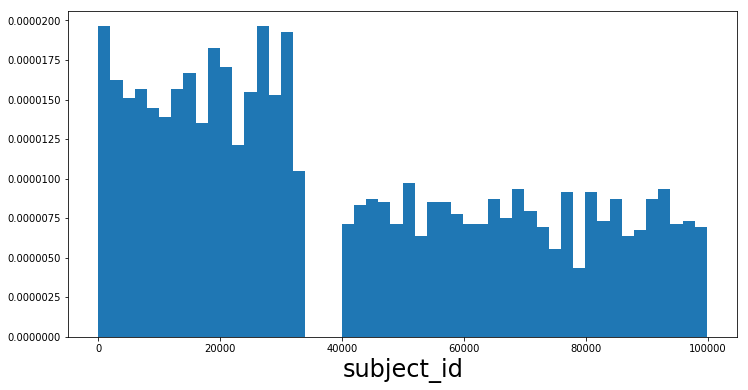

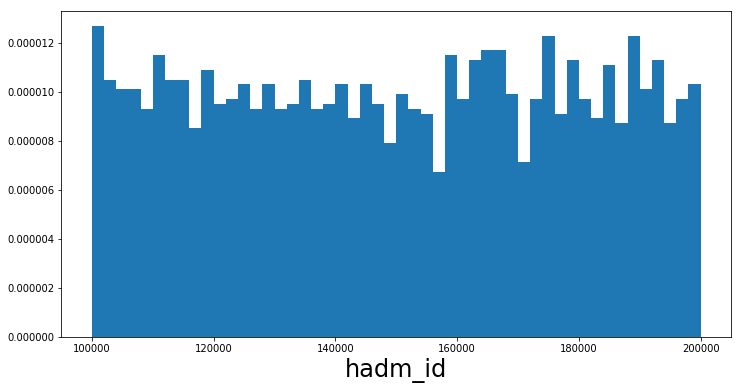

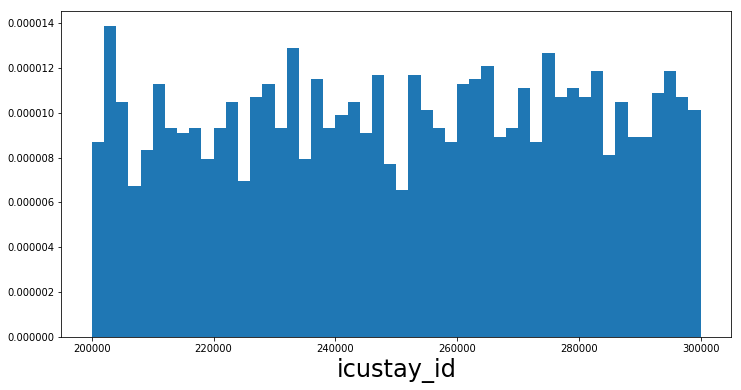

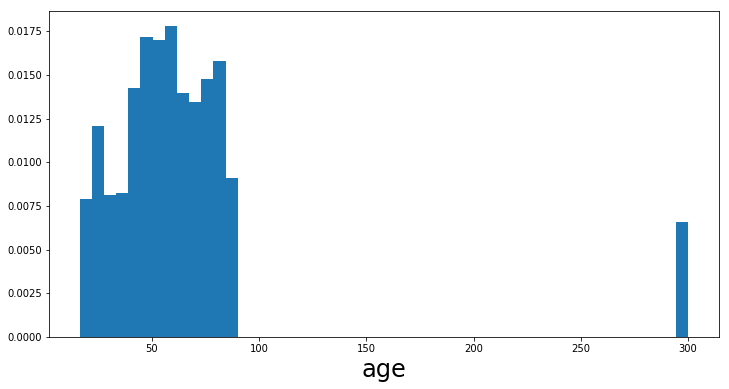

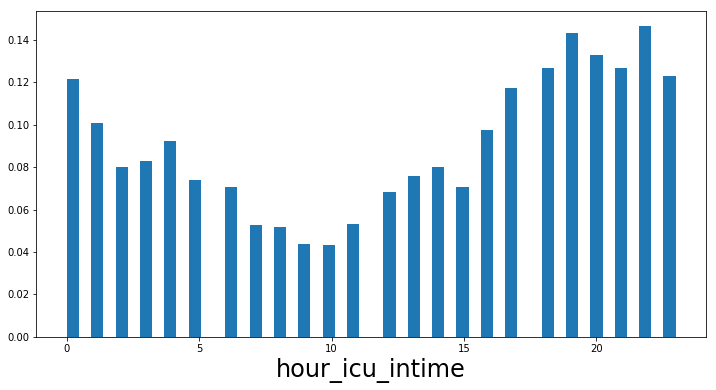

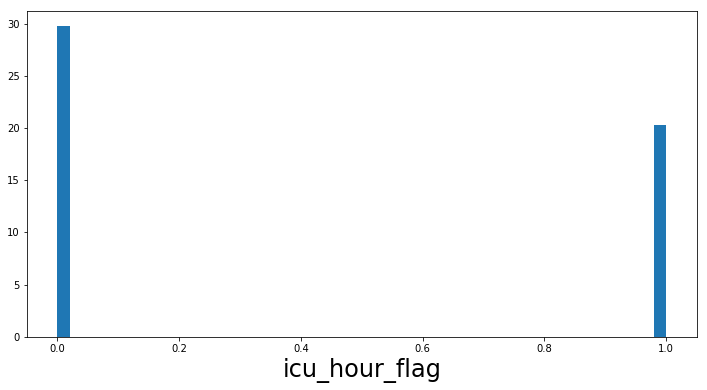

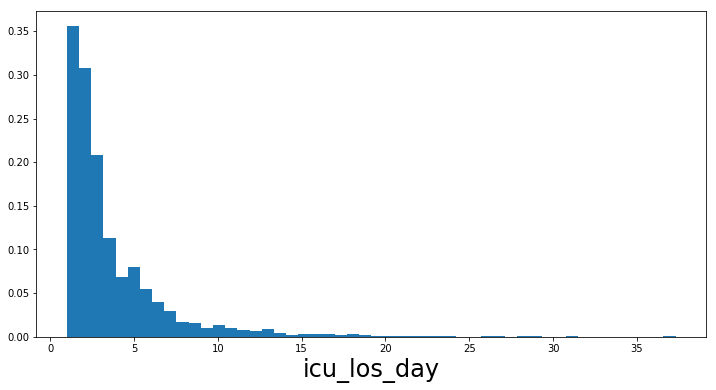

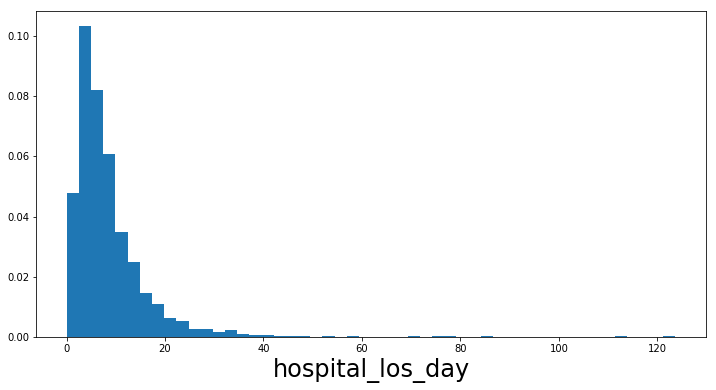

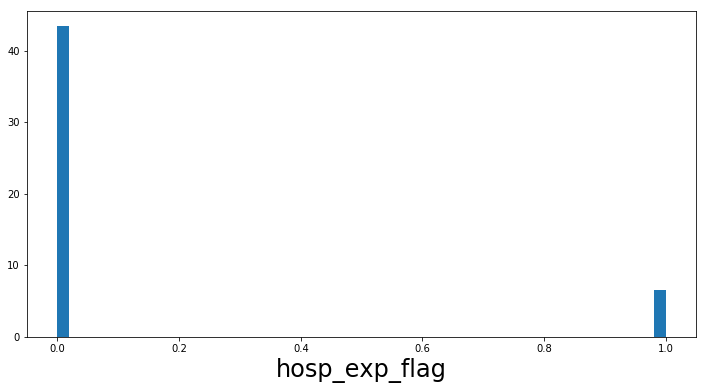

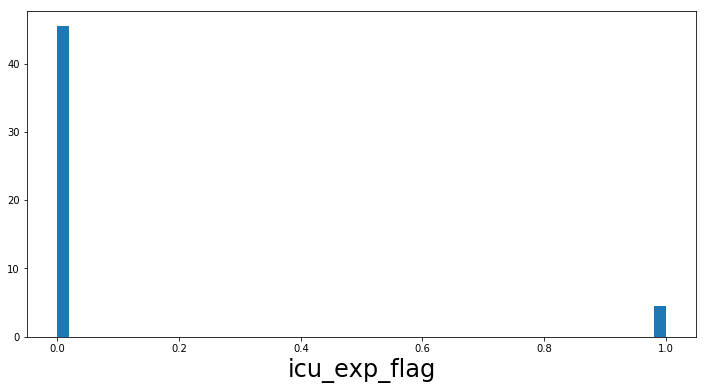

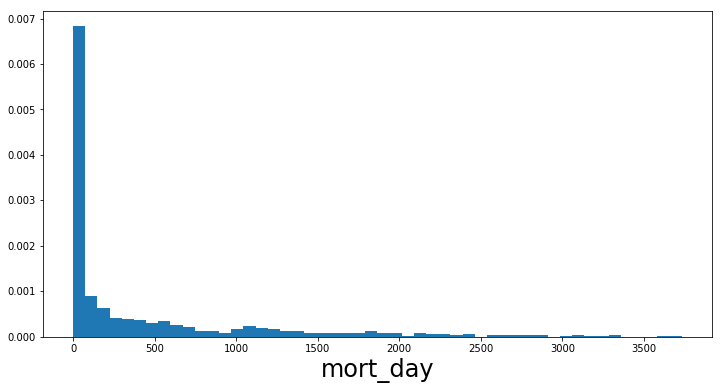

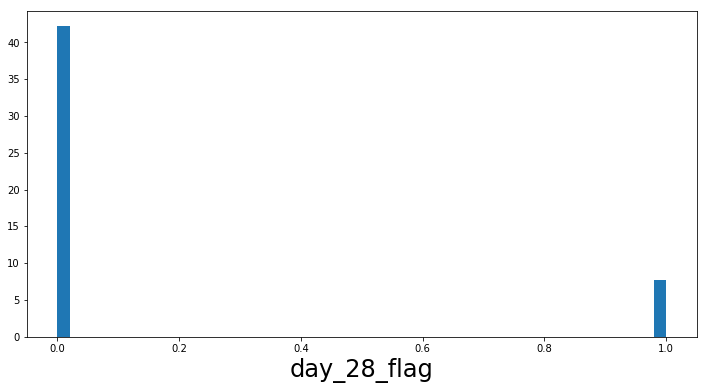

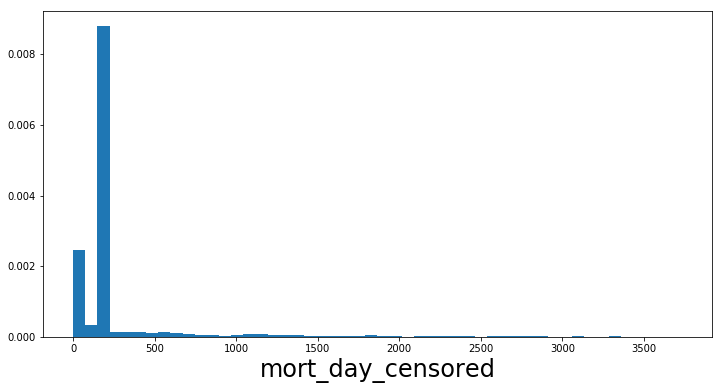

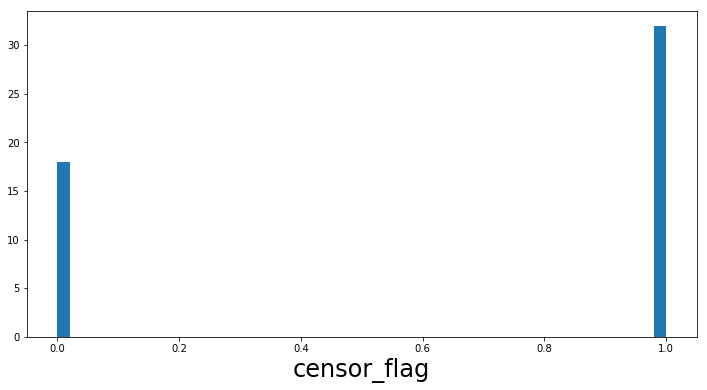

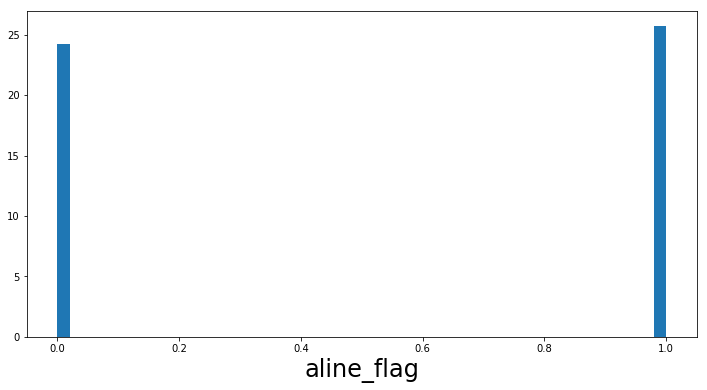

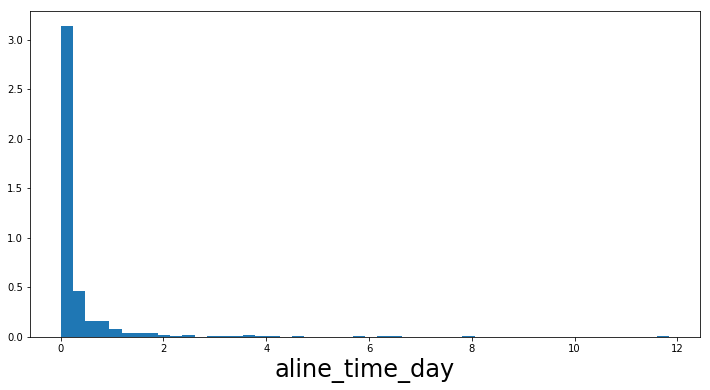

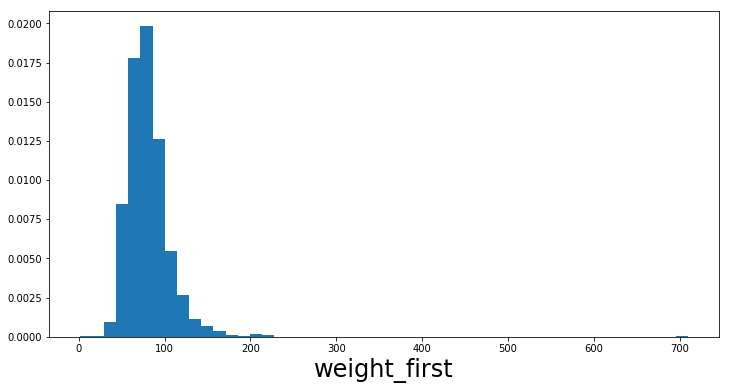

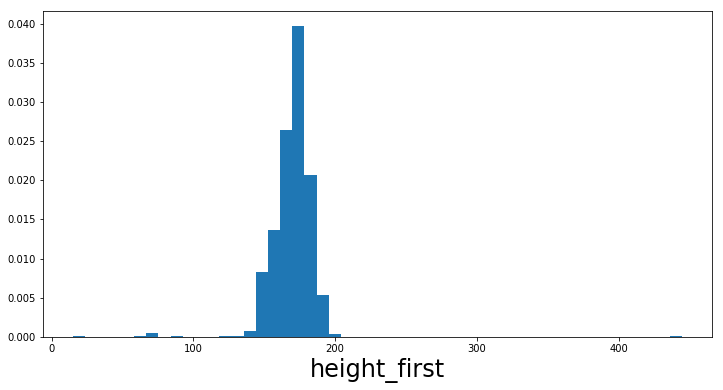

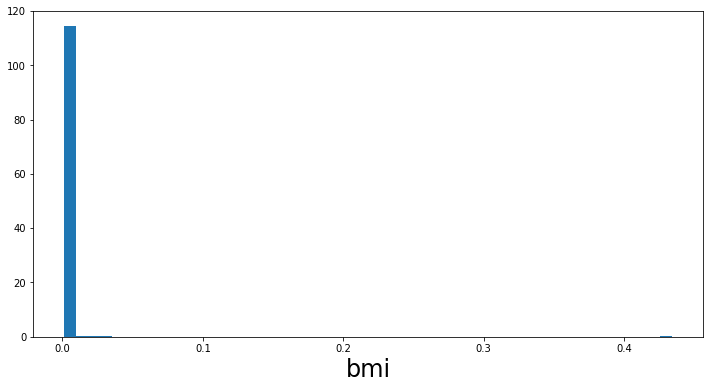

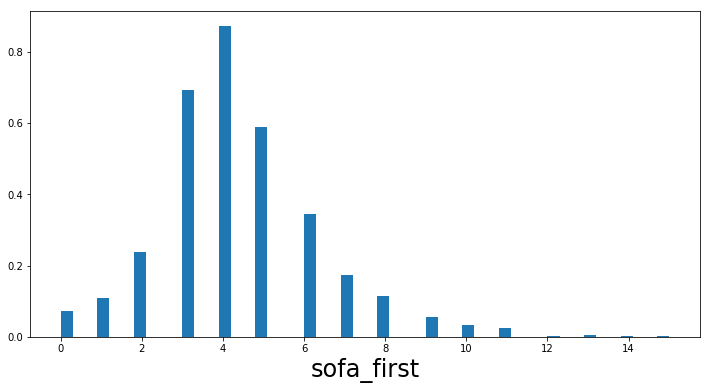

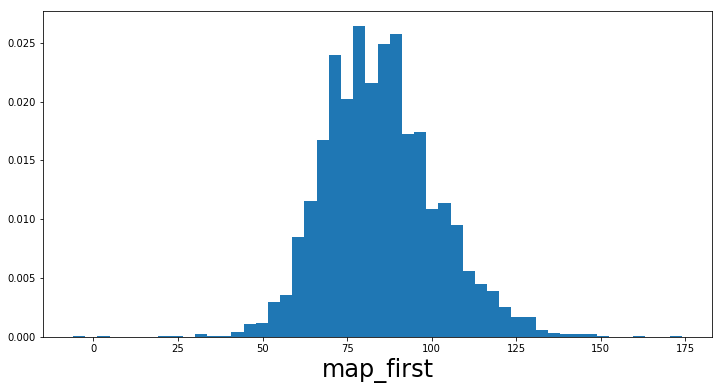

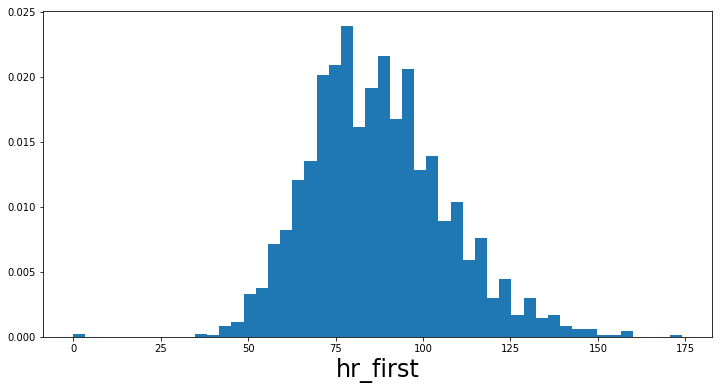

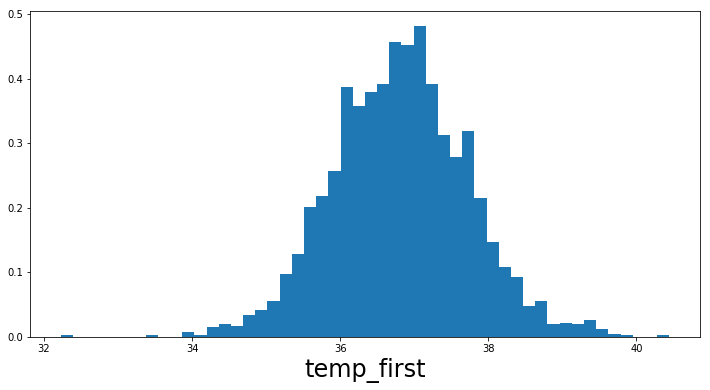

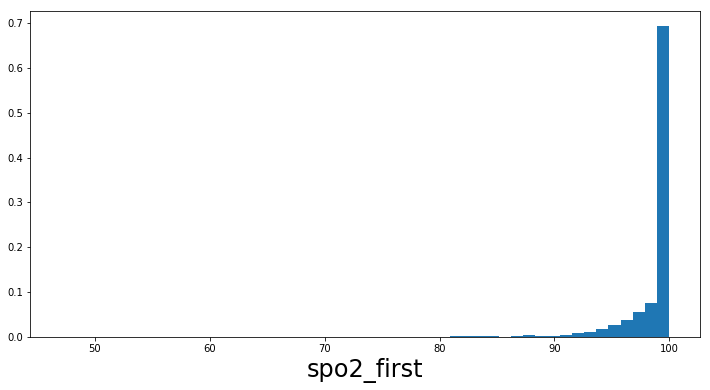

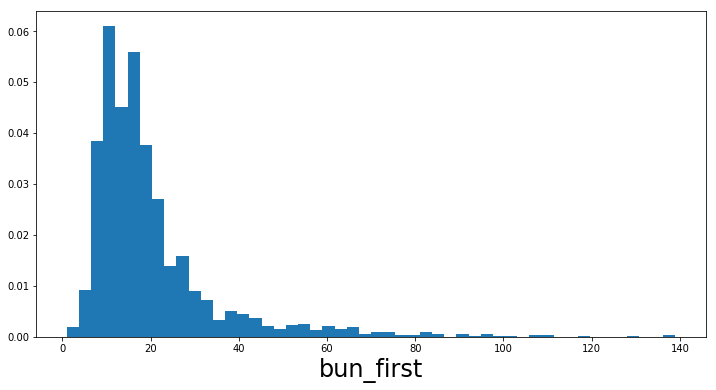

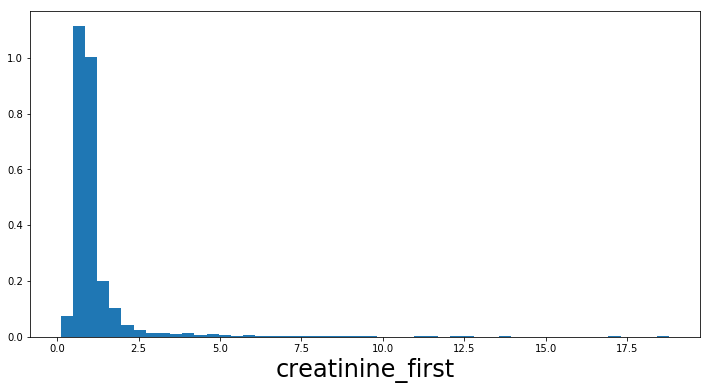

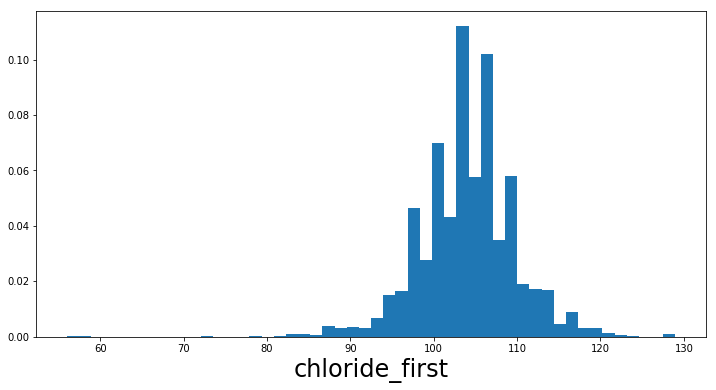

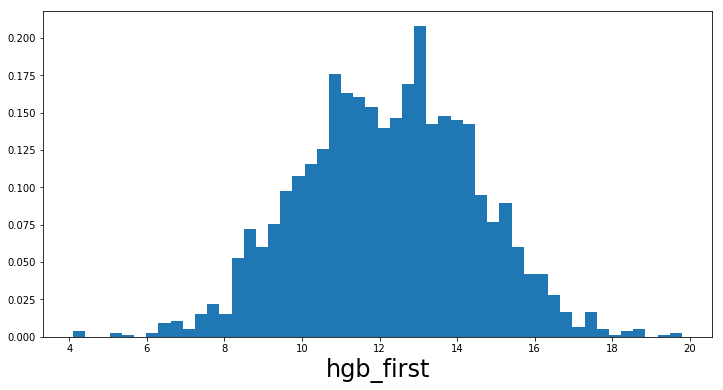

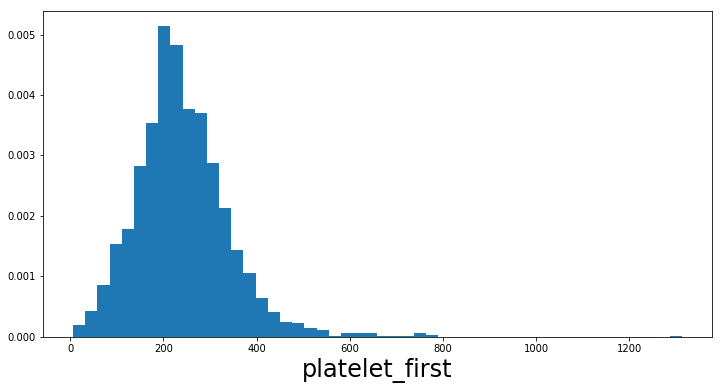

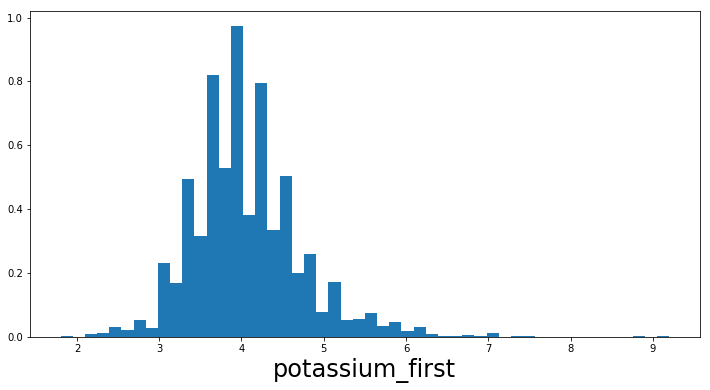

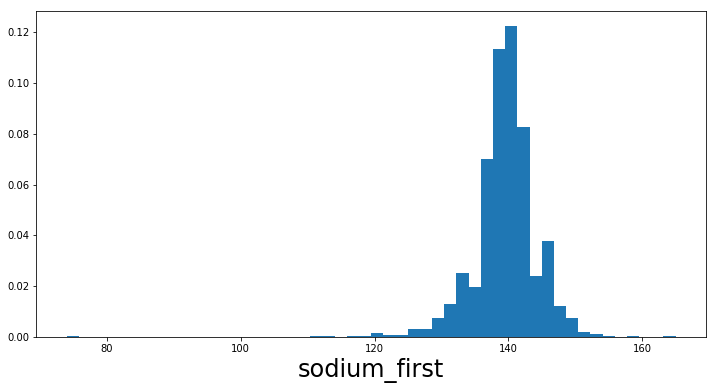

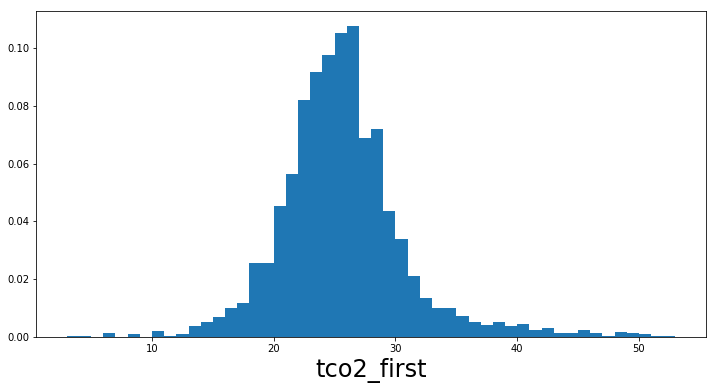

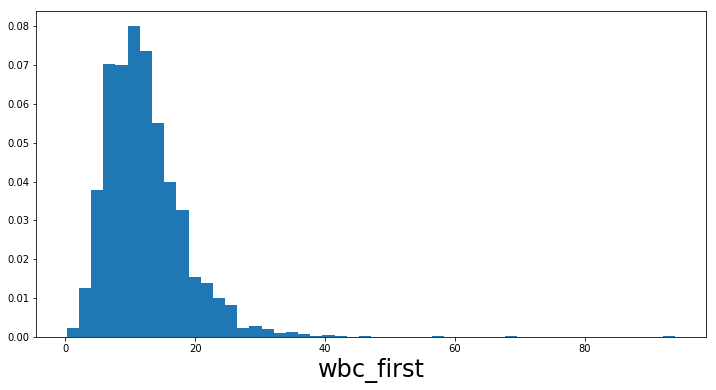

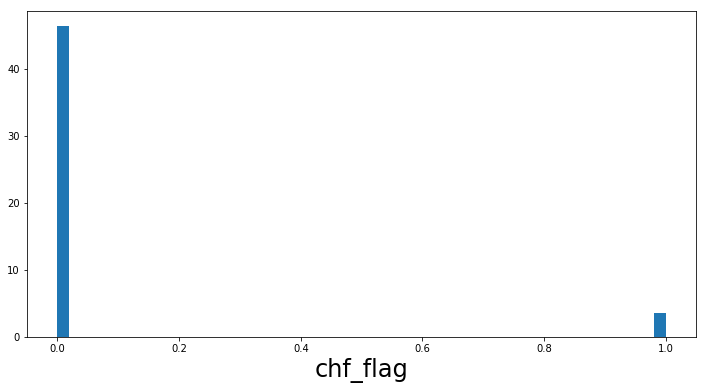

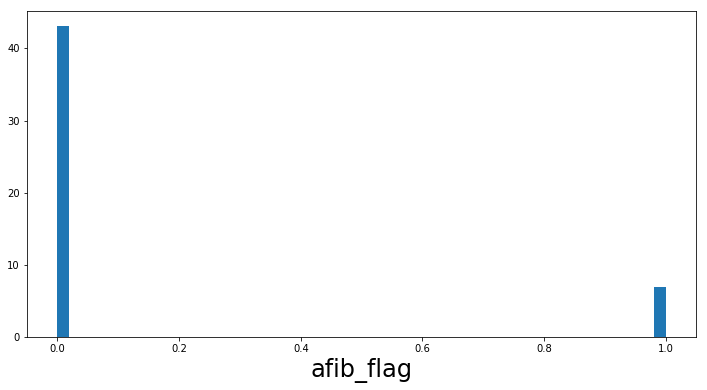

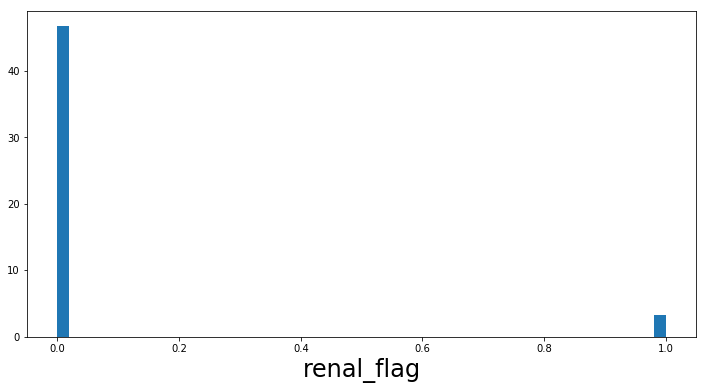

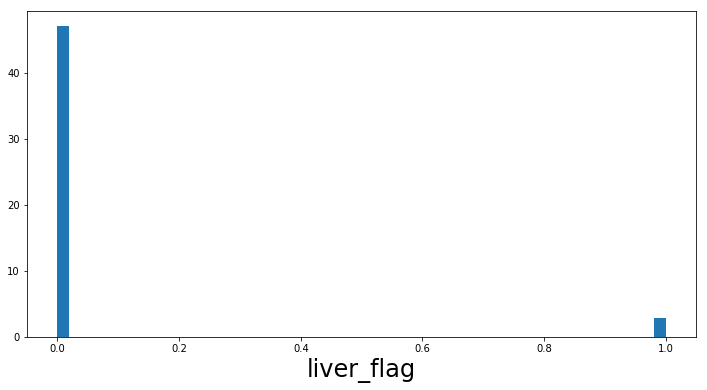

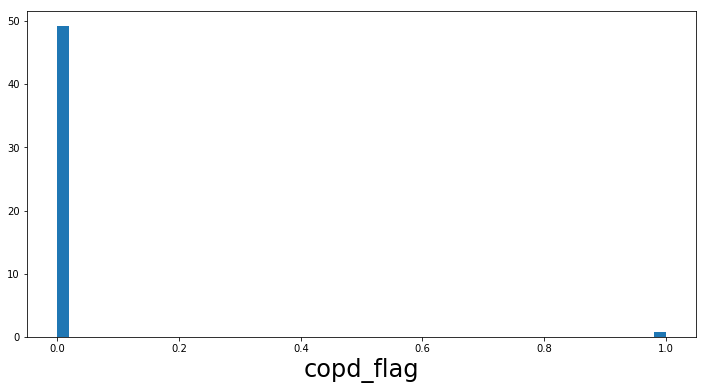

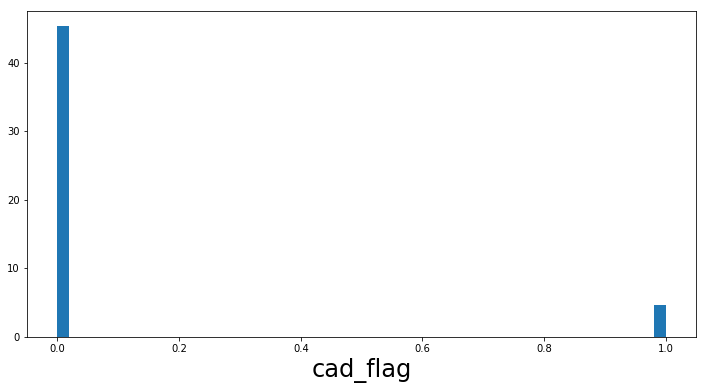

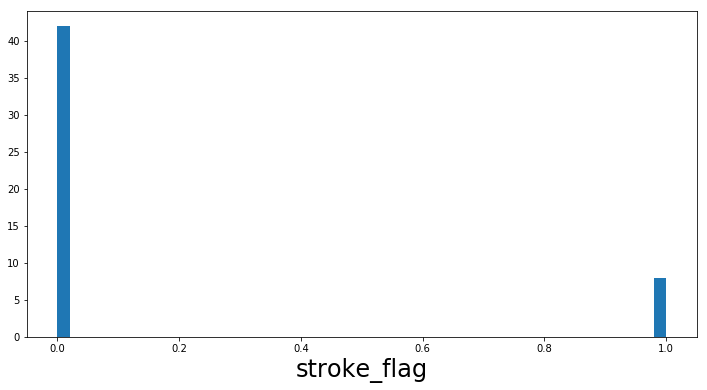

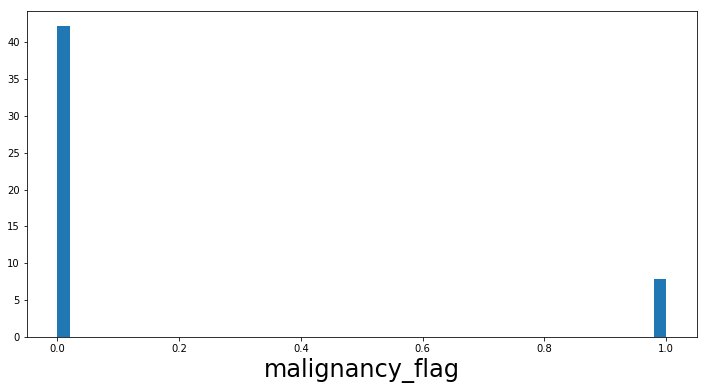

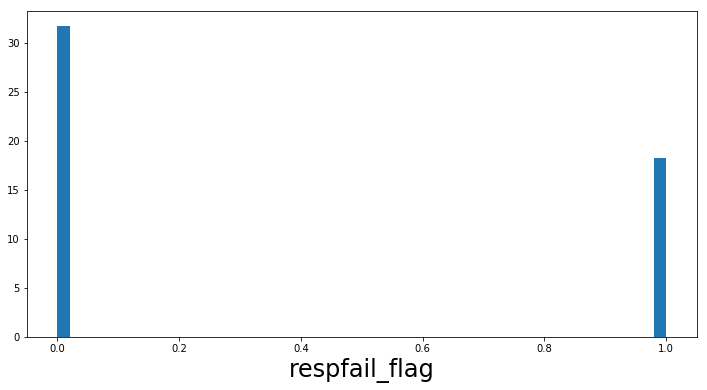

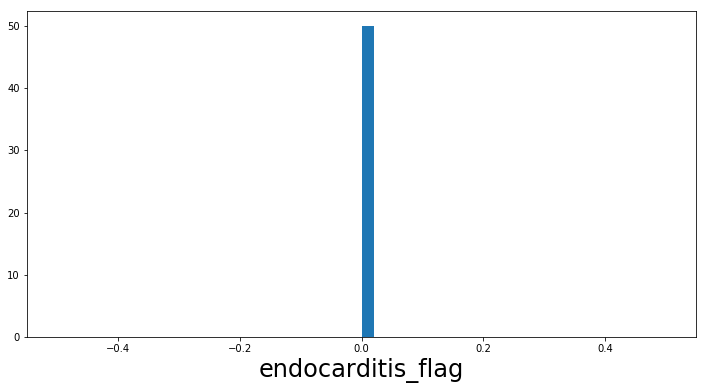

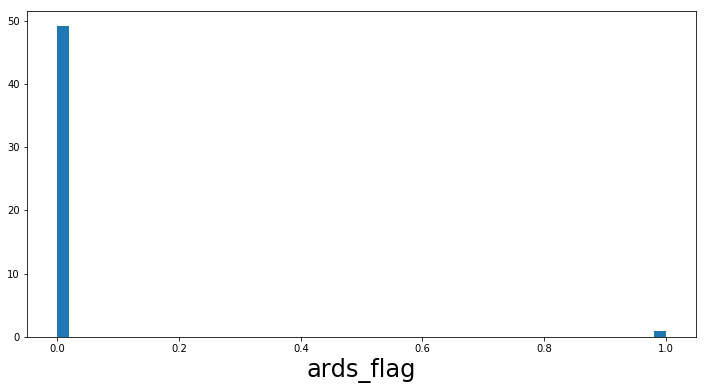

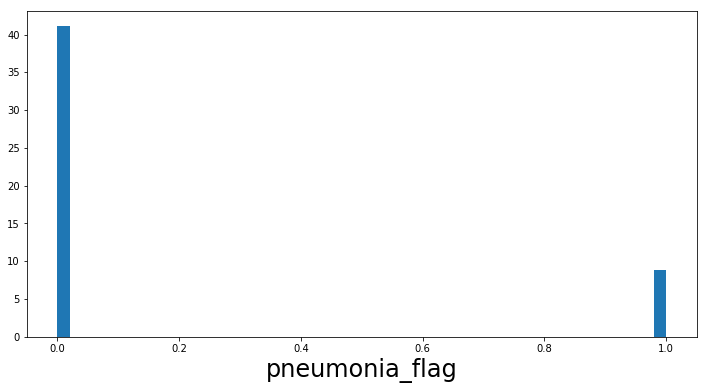

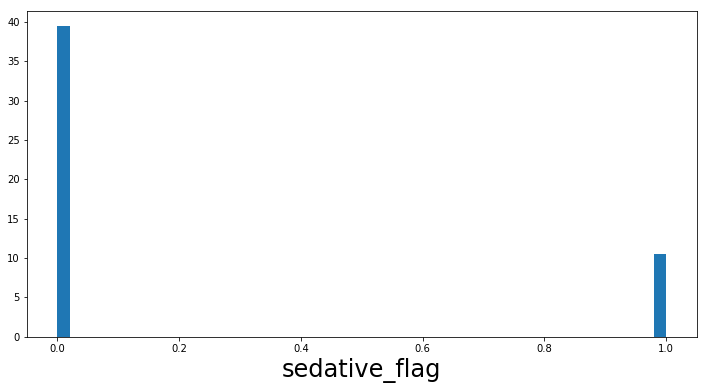

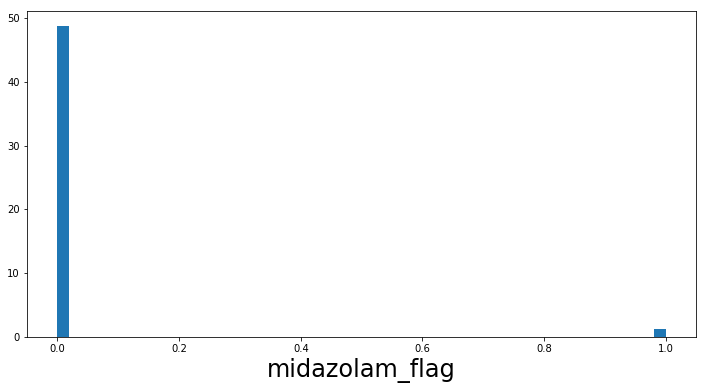

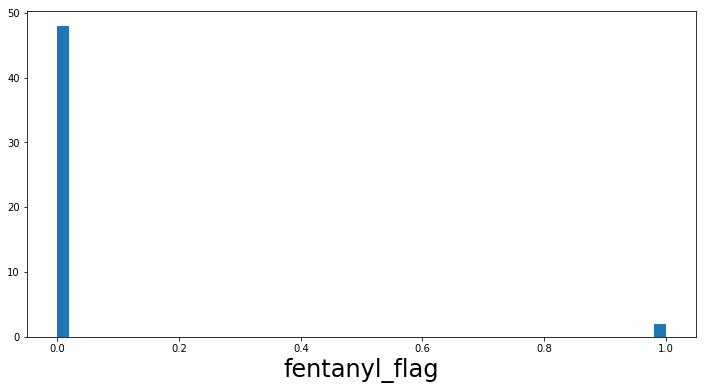

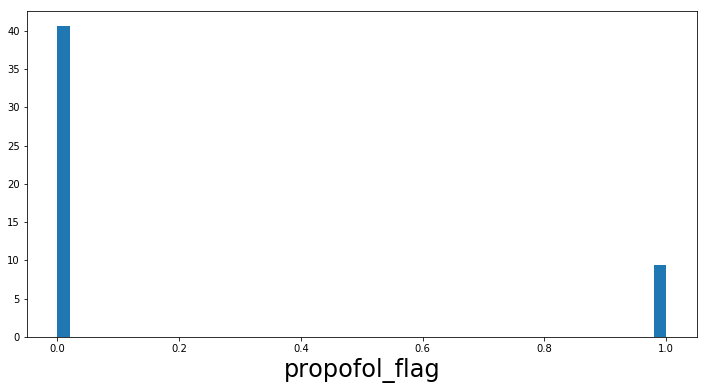

In [74]:
# plot the rest of the distributions
for col in df.columns:
    if df.dtypes[col] in ('int64','float64'):
        plt.figure(figsize=[12,6])
        plt.hist(df[col].dropna(), bins=50, normed=True)
        plt.xlabel(col,fontsize=24)
        plt.show()

In [75]:
# apply corrections
df.loc[df['age']>89, 'age'] = 91.4

# 3 - Write to file

In [76]:
df.to_csv('aline_data.csv',index=False)

In [77]:
print(datetime.datetime.now())

2019-06-04 17:15:29.634903


# 4 - Create a propensity score using this data

We will create the propensity score using R in the Jupyter Notebook file `aline_propensity_score.ipynb`.